# Gene Expression Data Visualization: Use PCA to Visualize Clusters of Genes Based on Their Expression Levels (GTEx Dataset)

## Overview
Gene expression datasets are inherently high-dimensional, often containing thousands of genes measured across hundreds of tissue samples, making it challenging to visualize patterns and identify tissue-specific expression signatures. Traditional approaches struggle with the curse of dimensionality when analyzing transcriptomic data, where thousands of genes create complex interdependencies that obscure biological relationships and tissue clustering patterns.

## You have:
- **Transcriptomic data**: 56,200+ genes measured across 838 donors and 52 different human tissue types from the GTEx (Genotype-Tissue Expression) project, including brain regions, cardiovascular tissues, digestive organs, endocrine glands, and reproductive tissues
- **Expression measurements**: RNA-seq read counts converted to TPM (Transcripts Per Million) values, log-transformed expression levels, and normalized gene expression matrices across diverse biological conditions
- **Sample metadata**: tissue type classifications, donor demographics, sample collection protocols, and batch information providing comprehensive biological context for expression patterns

## We will:
1. **Preprocess the GTEx gene expression matrix** by filtering low-expression genes, handling missing values, log-transforming count data, and standardizing expression levels across samples to prepare for dimensionality reduction
2. **Apply Principal Component Analysis** to reduce 56,200+ gene dimensions to 2-3 principal components while preserving the maximum variance that captures tissue-specific expression signatures
3. **Visualize tissue clustering patterns** in reduced dimensional space using scatter plots colored by tissue type to identify which tissues have similar expression profiles and which form distinct clusters
4. **Analyze component loadings** to identify the genes that contribute most strongly to tissue separation and understand the biological pathways driving the observed clustering patterns

## Goal
Computational biologists, biomedical researchers, and bioinformatics analysts can use this approach to rapidly visualize complex gene expression datasets, identify tissue-specific biomarkers, detect outlier samples, and understand the major sources of transcriptomic variation across human tissues. The dimensionality reduction enables intuitive exploration of high-dimensional biological data while revealing the underlying structure of gene expression patterns that distinguish different tissue types and biological states.


#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import base64
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

#### Notebook utility

In [7]:
image_paths = ["PCA_gif.gif", "PCA1.png", "PCA3.png", "PCA4.webp", "PCA5.webp", "PCA6.png"]
image_size = [1000, 700, 400, 600, 500, 500, 500, 500]
images_html = []

mime_map = {
    ".png": "image/png",
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".gif": "image/gif",
    ".webp": "image/webp"
}

for i, path in enumerate(image_paths):
    ext = os.path.splitext(path)[1].lower()
    mime = mime_map.get(ext, "image/png")

    with open("../img/"+path, "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

    img_tag = f'<img src="data:{mime};base64,{encoded}" style="display: block; margin-left: auto; margin-right: auto; width: {image_size[i]}px;" /><br>'
    images_html.append(img_tag)


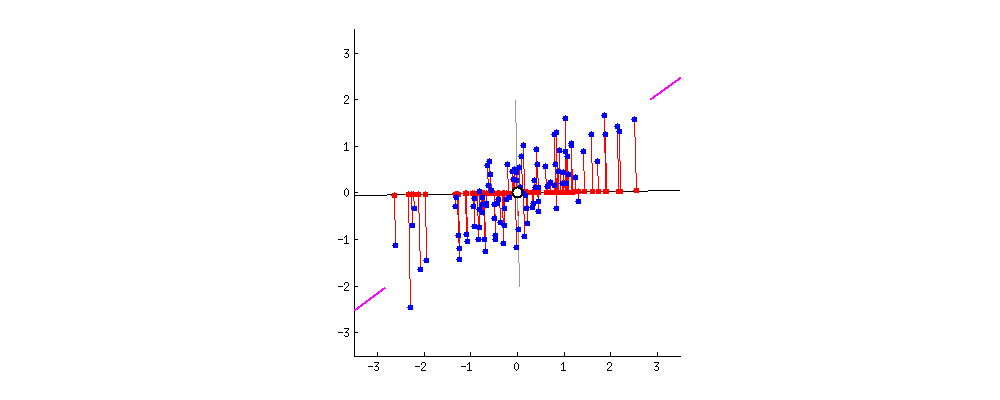

In [8]:
display(HTML(images_html[0]))


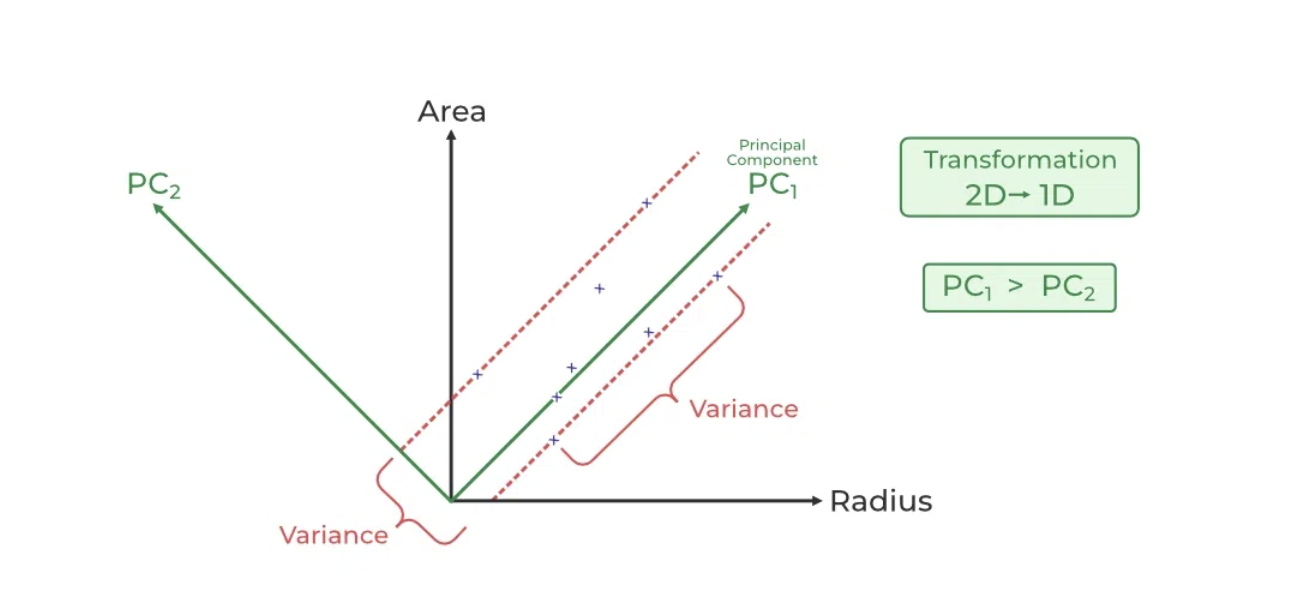

In [9]:
display(HTML(images_html[1]))


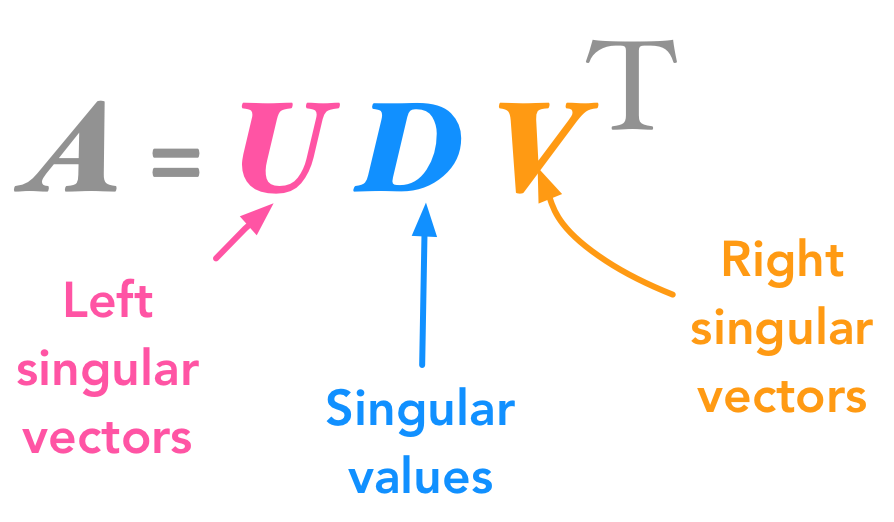

In [10]:
display(HTML(images_html[2]))


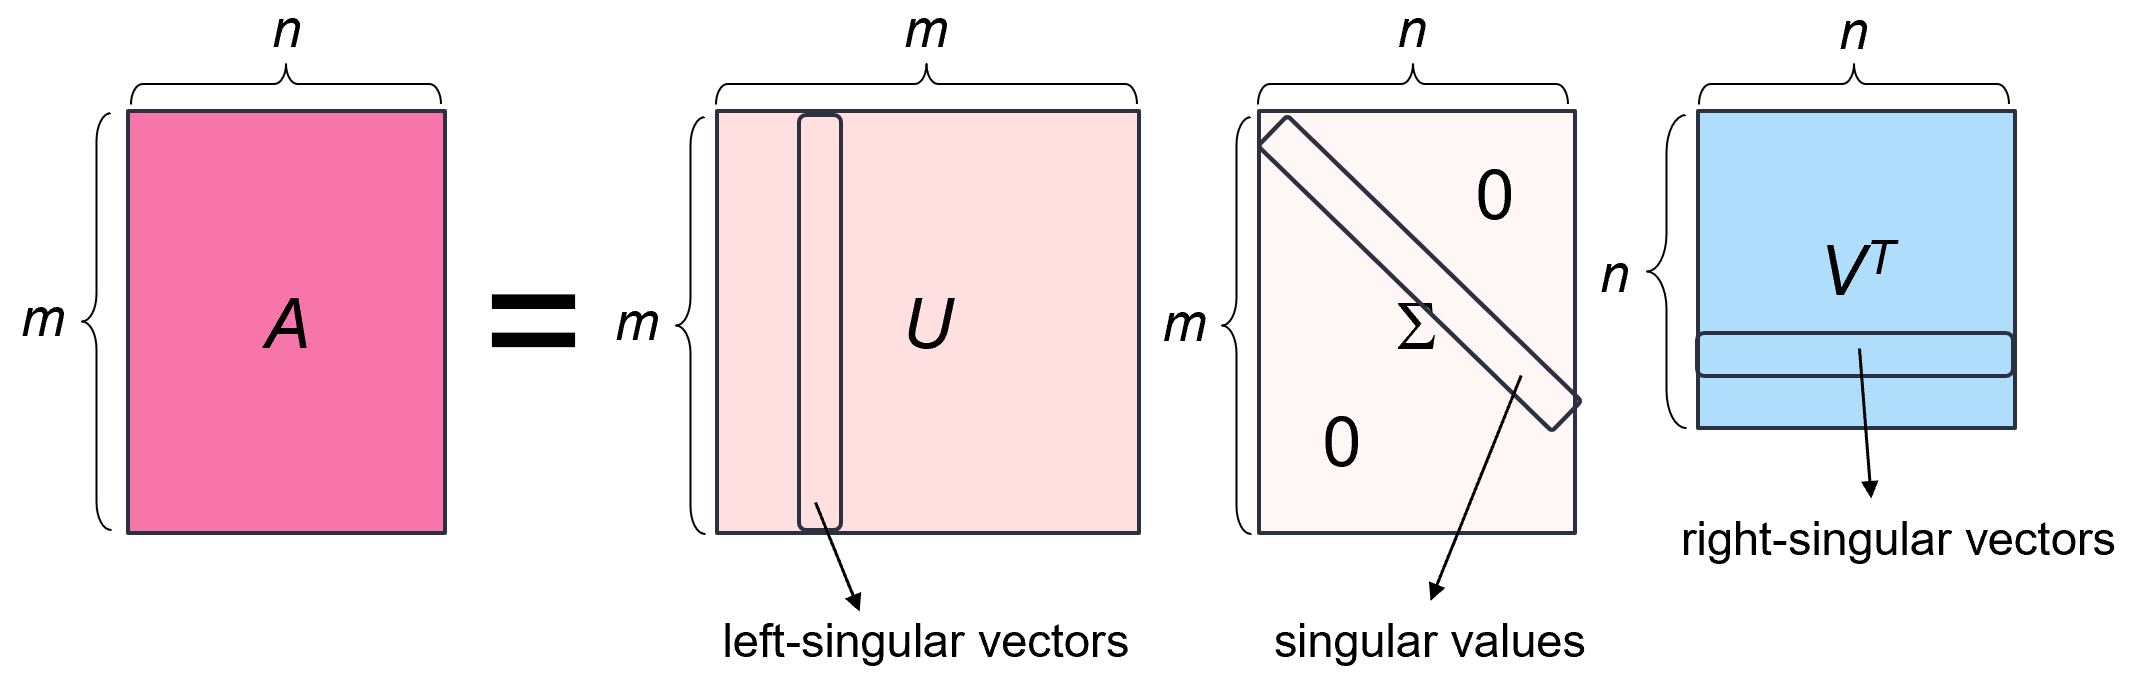

In [11]:
display(HTML(images_html[3]))


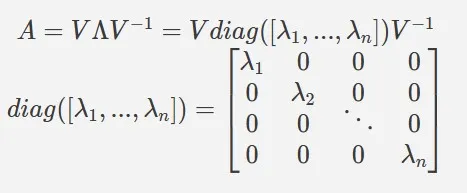

In [12]:
display(HTML(images_html[4]))


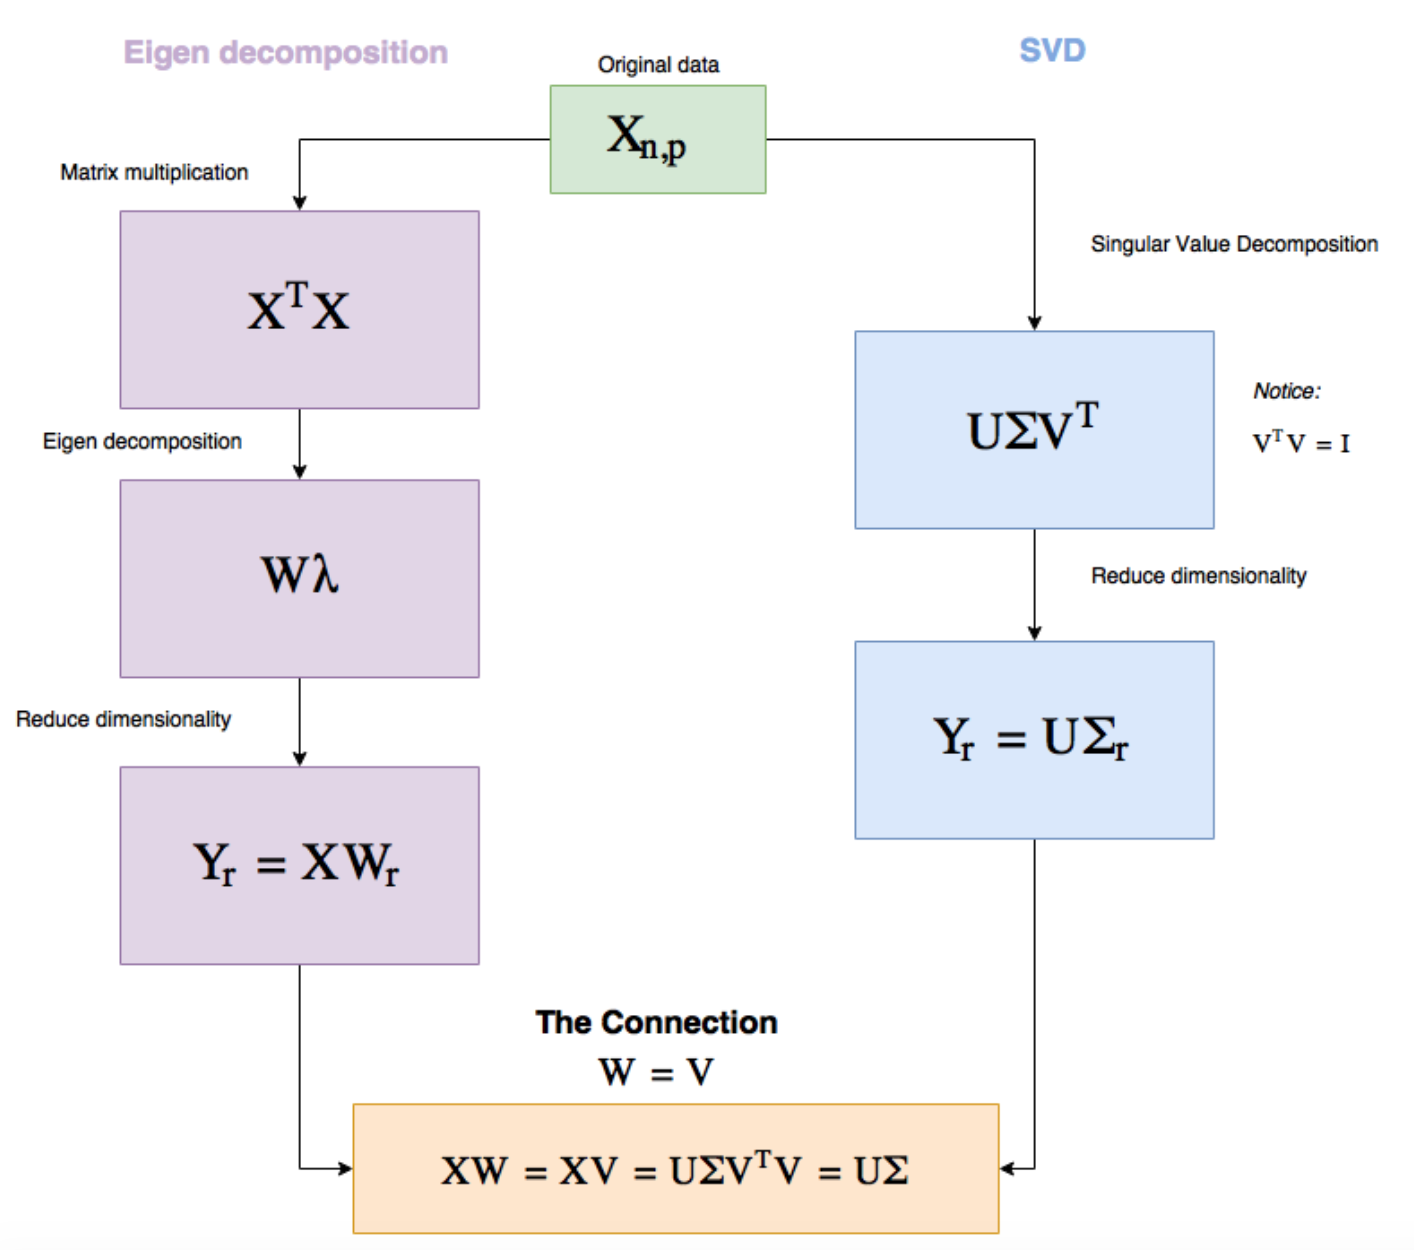

In [13]:
display(HTML(images_html[5]))

#### Loading the Dataset - GTEx Small RNA-seq 

In [2]:
file_path = "gtex_gene_expression_data.txt" 

try:
    # Load the dataset - GTEx files are typically tab-separated
    df = pd.read_csv(file_path, sep='\t', index_col=0)
    
    print(f"Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Number of genes: {df.shape[0]}")
    print(f"Number of samples: {df.shape[1]}")
    
    # Display first few rows and columns
    print("\nFirst 5 rows and 5 columns:")
    print(df.iloc[:5, :5])
    
except FileNotFoundError:
    print("Data Set Loading Error")


Dataset loaded successfully!
Dataset shape: (22482, 16761)
Number of genes: 22482
Number of samples: 16761

First 5 rows and 5 columns:
               GTEX-1117F-0005-SM-GMJZF  GTEX-1117F-0011-R3a-SM-GM3E3  \
URS000012A1DD                  0.000000                       0.00000   
URS00002B452B                  0.000000                       0.00000   
URS000023B77E                  0.000000                       0.00000   
URS00003DB428                  0.433135                      17.08322   
URS00001BB658                  0.000000                       0.00000   

               GTEX-1117F-0011-R7a-SM-GLFXK  GTEX-1117F-0226-SM-DEURW  \
URS000012A1DD                      1.996986                  8.997750   
URS00002B452B                      0.000000                  0.000000   
URS000023B77E                      0.000000                  0.000000   
URS00003DB428                     25.965643                 68.054364   
URS00001BB658                      0.000000                 

#### Exploring Dataset

In [8]:
# Check data types
print(f"Data types:")
print(df.dtypes.value_counts())

# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"\n Total missing values: {missing_values}")
print(f"Missing value percentage: {(missing_values / df.size) * 100:.2f}%")

# Basic statistics
print(f"\nExpression value statistics:")
print(df.describe().iloc[:, :5])  # Show stats for first 5 samples

# Check if sample names contain tissue information
print(f"\nSample name examples:")
sample_names = df.columns[:10].tolist()
for i, sample in enumerate(sample_names):
    print(f"  {i+1}. {sample}")

# Extract tissue information from sample names (GTEx format: GTEX-ID-TISSUE-SAMPLE)
# This assumes GTEx naming convention
tissue_info = []
for sample in df.columns:
    # GTEx samples typically have tissue info in the sample name
    # Format: GTEX-DONOR-TISSUE-SAMPLE
    parts = sample.split('-')
    if len(parts) >= 3:
        tissue_info.append(parts[2])  # Extract tissue part
    else:
        tissue_info.append('Unknown')

# Create tissue mapping
tissue_series = pd.Series(tissue_info, index=df.columns)
unique_tissues = tissue_series.value_counts()

print(f"\nTissue distribution:")
print(unique_tissues.head(10))
print(f"Total unique tissues: {len(unique_tissues)}")


Data types:
float64    16761
Name: count, dtype: int64

 Total missing values: 0
Missing value percentage: 0.00%

Expression value statistics:
       GTEX-1117F-0005-SM-GMJZF  GTEX-1117F-0011-R3a-SM-GM3E3  \
count              22482.000000                  22482.000000   
mean                  31.489454                    174.479150   
std                 1235.259465                   7186.372606   
min                    0.000000                      0.000000   
25%                    0.000000                      0.000000   
50%                    0.000000                      0.000000   
75%                    0.000000                      0.000000   
max                82891.700000                 734895.777178   

       GTEX-1117F-0011-R7a-SM-GLFXK  GTEX-1117F-0226-SM-DEURW  \
count                  22482.000000              22482.000000   
mean                      87.671018                 21.995705   
std                     2508.642680               1206.119845   
min        

#### Data preprocessing and Standardisation

#### Why standardization is important for PCA
- Genes have different expression ranges (some 0-10, others 0-1000)
- PCA is sensitive to variable scales
- Standardization ensures each gene contributes equally to PCA

In [4]:
# Handle missing values
# Remove genes with too many missing values (>20% missing)
missing_threshold = 0.2
genes_to_keep = df.isnull().mean(axis=1) <= missing_threshold
df_clean = df.loc[genes_to_keep]

print(f"   Removed {df.shape[0] - df_clean.shape[0]} genes with >{missing_threshold*100}% missing values")
print(f"   Remaining genes: {df_clean.shape[0]}")

# Impute remaining missing values with median
if df_clean.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='median')
    df_clean = pd.DataFrame(
        imputer.fit_transform(df_clean.T).T,  # Transpose for gene-wise imputation
        index=df_clean.index,
        columns=df_clean.columns
    )
    print("Imputed remaining missing values with median")

# Filter low-expression genes
print("\nFiltering low-expression genes...")

# Keep genes with mean expression > 1 TPM across all samples
mean_expression = df_clean.mean(axis=1)
high_expr_genes = mean_expression > 1
df_filtered = df_clean.loc[high_expr_genes]

print(f"   Removed {df_clean.shape[0] - df_filtered.shape[0]} low-expression genes")
print(f"   Remaining genes: {df_filtered.shape[0]}")

# Prepare data for PCA
print("\nPreparing data for PCA...")

# Transpose data: samples as rows, genes as columns (required for PCA)
expression_matrix = df_filtered.T
print(f"Expression matrix shape: {expression_matrix.shape}")

# Prepare tissue labels
tissue_labels = pd.Series(tissue_info, index=df.columns)
tissue_labels = tissue_labels[expression_matrix.index]  # Align with filtered data

# Standardize the data
print("\nStandardizing gene expression values...")

scaler = StandardScaler()
expression_scaled = scaler.fit_transform(expression_matrix)

print("Data standardized (mean=0, std=1 for each gene)")
print(f"Scaled data shape: {expression_scaled.shape}")


print(f"Final dataset: {expression_scaled.shape[0]} samples × {expression_scaled.shape[1]} genes")


   Removed 0 genes with >20.0% missing values
   Remaining genes: 22482

Filtering low-expression genes...
   Removed 19092 low-expression genes
   Remaining genes: 3390

Preparing data for PCA...
Expression matrix shape: (16761, 3390)

Standardizing gene expression values...
Data standardized (mean=0, std=1 for each gene)
Scaled data shape: (16761, 3390)
Final dataset: 16761 samples × 3390 genes


#### Applying PCA

Applying PCA with 2 components...
PC1 explains 0.352 (35.2%) of variance
PC2 explains 0.136 (13.6%) of variance
Total variance explained: 0.488 (48.8%)

Analyzing variance explained by multiple components...


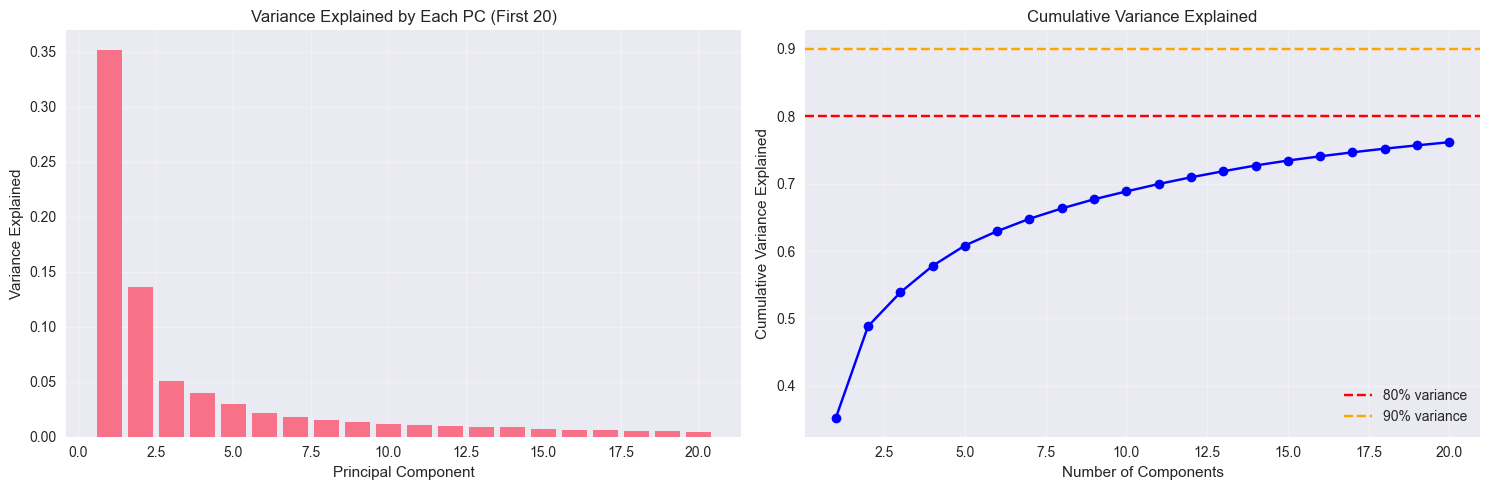

Components needed for 80% variance: 32
Components needed for 90% variance: 1

PCA analysis complete!
PCA results shape: (16761, 3)


In [5]:
#Initialize PCA with 2 components for visualization
print("Applying PCA with 2 components...")

pca_2d = PCA(n_components=2, random_state=42)
pca_result_2d = pca_2d.fit_transform(expression_scaled)

# Calculate explained variance
explained_variance_2d = pca_2d.explained_variance_ratio_
cumulative_variance_2d = np.cumsum(explained_variance_2d)

print(f"PC1 explains {explained_variance_2d[0]:.3f} ({explained_variance_2d[0]*100:.1f}%) of variance")
print(f"PC2 explains {explained_variance_2d[1]:.3f} ({explained_variance_2d[1]*100:.1f}%) of variance")
print(f"Total variance explained: {cumulative_variance_2d[1]:.3f} ({cumulative_variance_2d[1]*100:.1f}%)")

# Apply PCA with more components to see variance explained
print("\nAnalyzing variance explained by multiple components...")

pca_multi = PCA(n_components=min(50, expression_scaled.shape[1]), random_state=42)
pca_multi.fit(expression_scaled)

explained_variance_multi = pca_multi.explained_variance_ratio_
cumulative_variance_multi = np.cumsum(explained_variance_multi)

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Individual variance explained
ax1.bar(range(1, len(explained_variance_multi[:20]) + 1), explained_variance_multi[:20])
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained')
ax1.set_title('Variance Explained by Each PC (First 20)')
ax1.grid(True, alpha=0.3)

# Cumulative variance explained
ax2.plot(range(1, len(cumulative_variance_multi[:20]) + 1), cumulative_variance_multi[:20], 'bo-')
ax2.axhline(y=0.8, color='r', linestyle='--', label='80% variance')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.set_title('Cumulative Variance Explained')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 80% and 90% variance
n_components_80 = np.argmax(cumulative_variance_multi >= 0.8) + 1
n_components_90 = np.argmax(cumulative_variance_multi >= 0.9) + 1

print(f"Components needed for 80% variance: {n_components_80}")
print(f"Components needed for 90% variance: {n_components_90}")

# Create DataFrame for PCA results
pca_df = pd.DataFrame(
    pca_result_2d,
    columns=['PC1', 'PC2'],
    index=expression_matrix.index
)
pca_df['Tissue'] = tissue_labels.values

print(f"\nPCA analysis complete!")
print(f"PCA results shape: {pca_df.shape}")


#### Visualize PCA results

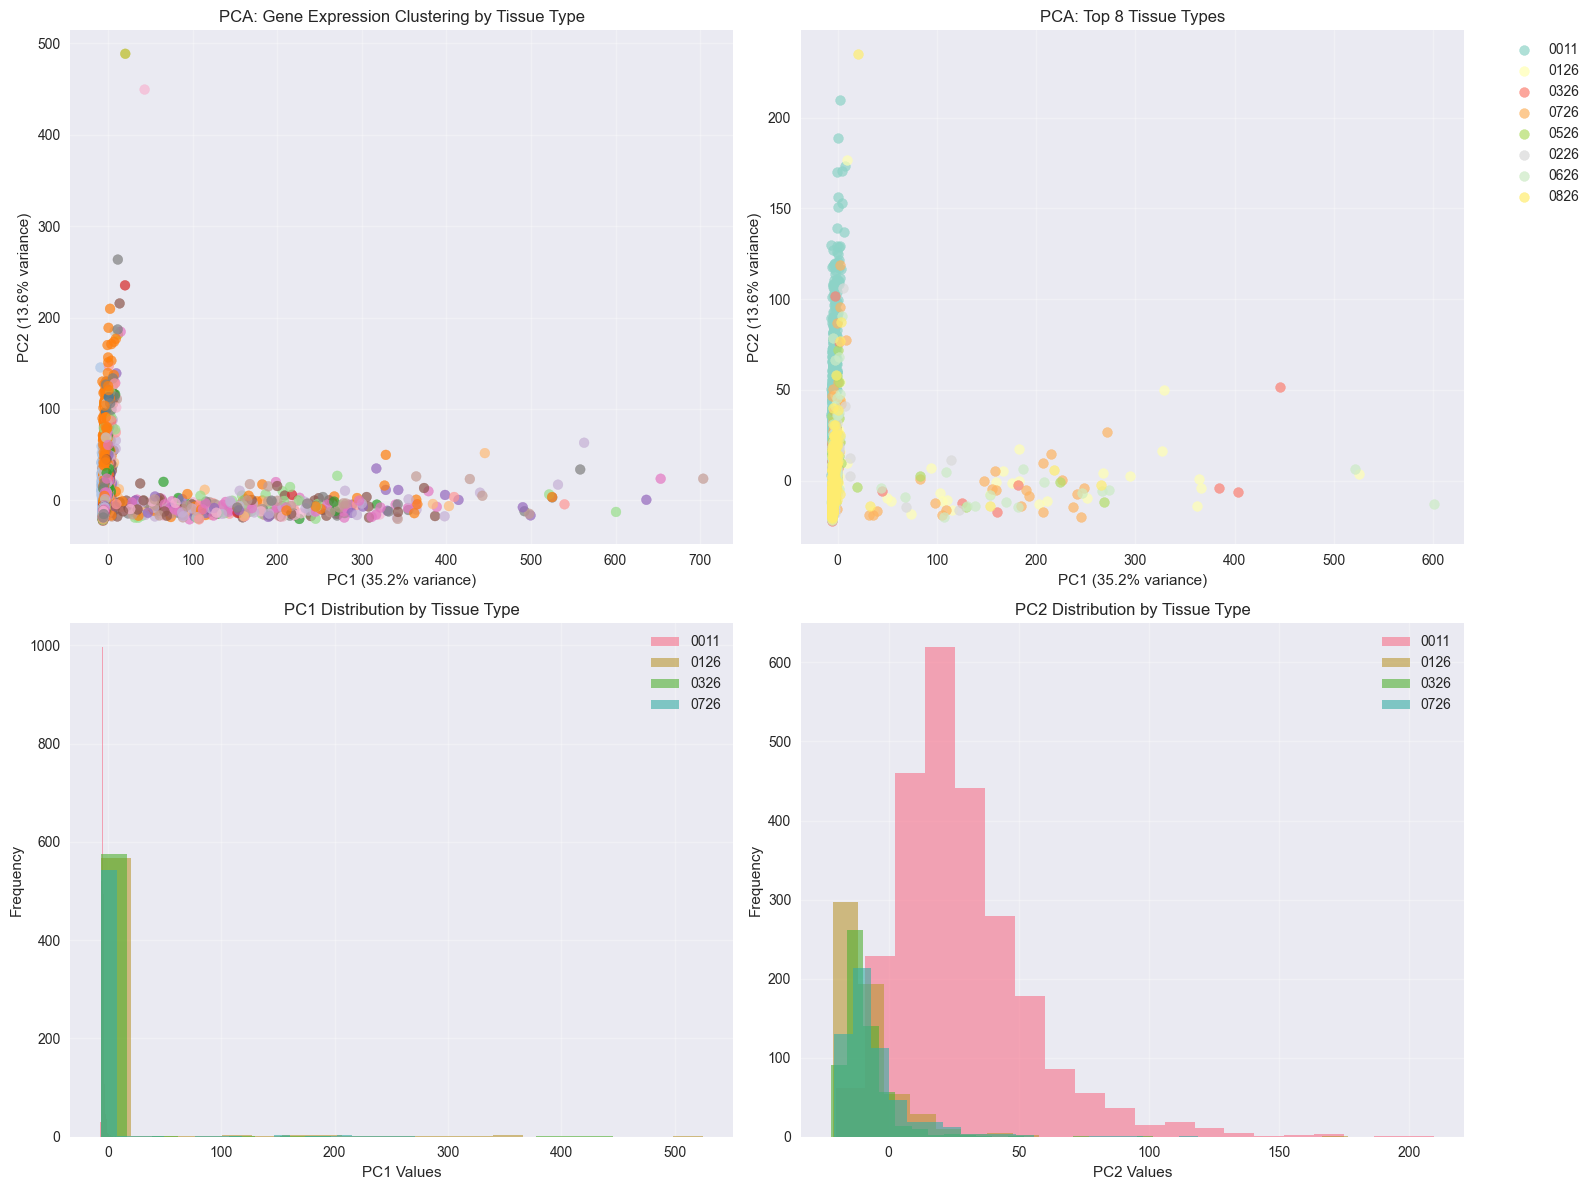

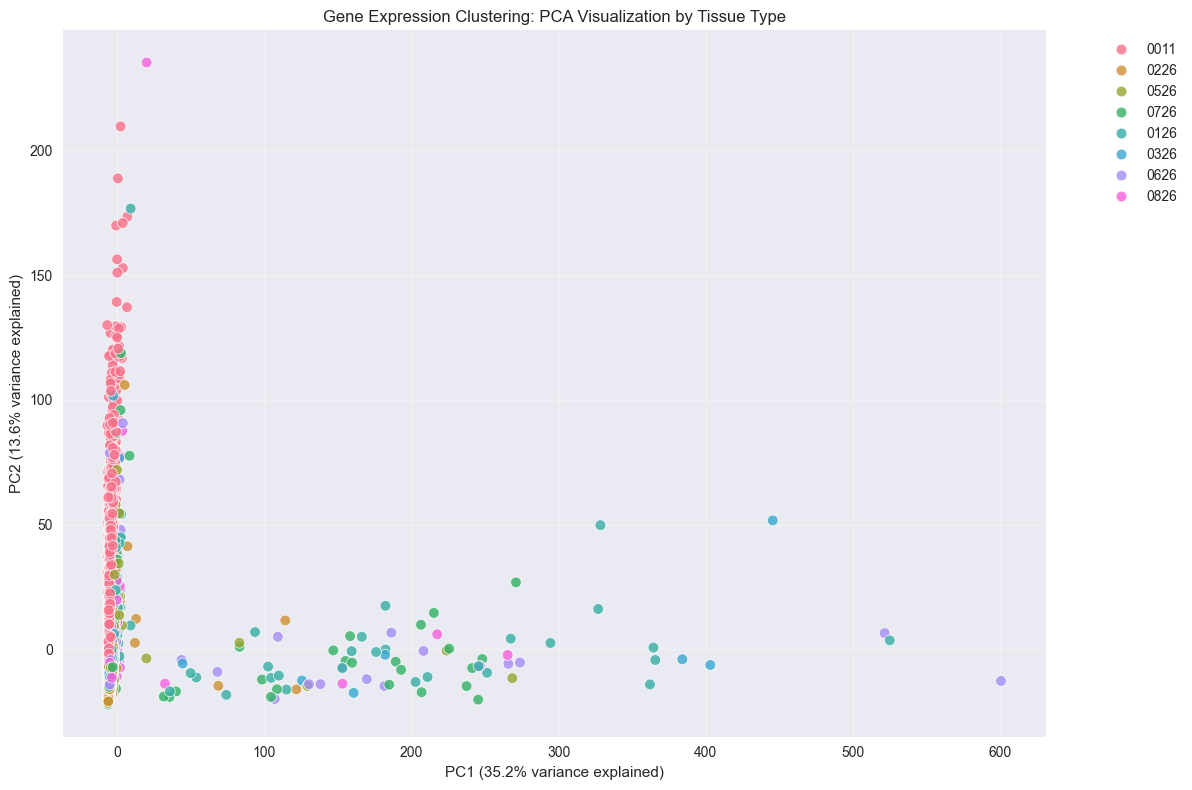

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Basic PCA scatter plot
ax1 = axes[0, 0]
scatter = ax1.scatter(pca_df['PC1'], pca_df['PC2'], 
                     c=pd.Categorical(pca_df['Tissue']).codes, 
                     cmap='tab20', alpha=0.7, s=50)
ax1.set_xlabel(f'PC1 ({explained_variance_2d[0]*100:.1f}% variance)')
ax1.set_ylabel(f'PC2 ({explained_variance_2d[1]*100:.1f}% variance)')
ax1.set_title('PCA: Gene Expression Clustering by Tissue Type')
ax1.grid(True, alpha=0.3)

# Plot 2: PCA with tissue labels (top tissues only for clarity)
ax2 = axes[0, 1]
top_tissues = tissue_labels.value_counts().head(8).index
colors = plt.cm.Set3(np.linspace(0, 1, len(top_tissues)))

for i, tissue in enumerate(top_tissues):
    mask = pca_df['Tissue'] == tissue
    if mask.sum() > 0:  # Only plot if tissue has samples
        ax2.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                   c=[colors[i]], label=tissue, alpha=0.7, s=50)

ax2.set_xlabel(f'PC1 ({explained_variance_2d[0]*100:.1f}% variance)')
ax2.set_ylabel(f'PC2 ({explained_variance_2d[1]*100:.1f}% variance)')
ax2.set_title('PCA: Top 8 Tissue Types')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Density plot of PC1
ax3 = axes[1, 0]
for tissue in top_tissues[:4]:  # Show top 4 for clarity
    mask = pca_df['Tissue'] == tissue
    if mask.sum() > 0:
        ax3.hist(pca_df.loc[mask, 'PC1'], alpha=0.6, label=tissue, bins=20)
ax3.set_xlabel('PC1 Values')
ax3.set_ylabel('Frequency')
ax3.set_title('PC1 Distribution by Tissue Type')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Density plot of PC2
ax4 = axes[1, 1]
for tissue in top_tissues[:4]:  # Show top 4 for clarity
    mask = pca_df['Tissue'] == tissue
    if mask.sum() > 0:
        ax4.hist(pca_df.loc[mask, 'PC2'], alpha=0.6, label=tissue, bins=20)
ax4.set_xlabel('PC2 Values')
ax4.set_ylabel('Frequency')
ax4.set_title('PC2 Distribution by Tissue Type')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a more detailed seaborn plot
plt.figure(figsize=(12, 8))

# Use only top tissues for better visualization
pca_df_filtered = pca_df[pca_df['Tissue'].isin(top_tissues)]

sns.scatterplot(data=pca_df_filtered, x='PC1', y='PC2', hue='Tissue', 
                s=60, alpha=0.8)
plt.xlabel(f'PC1 ({explained_variance_2d[0]*100:.1f}% variance explained)')
plt.ylabel(f'PC2 ({explained_variance_2d[1]*100:.1f}% variance explained)')
plt.title('Gene Expression Clustering: PCA Visualization by Tissue Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### Analyze clustering patterns and explore 3D visualization


Tissue centroids in PC space:
   0001            | PC1:  -3.85 | PC2:   4.53 | Samples:  85
   0002            | PC1:  -4.08 | PC2:   1.78 | Samples:  59
   0003            | PC1:  -4.08 | PC2:   1.61 | Samples:  54
   0004            | PC1:  -4.09 | PC2:  -1.12 | Samples:  35
   0005            | PC1:  -6.28 | PC2:   0.52 | Samples: 346
   0006            | PC1:  -6.24 | PC2:  -0.12 | Samples: 340
   0007            | PC1:  -6.03 | PC2:  -7.44 | Samples:   3
   0008            | PC1:  -4.45 | PC2: -12.25 | Samples: 528
   0011            | PC1:  -4.49 | PC2:  28.08 | Samples: 2502
   0126            | PC1:   5.47 | PC2:  -7.78 | Samples: 594

Calculating tissue clustering tightness...
🎯 Tissue clustering tightness (lower = more clustered):
   0226            | Variance: 83.476
   0526            | Variance: 195.116
   0826            | Variance: 262.724
   0011            | Variance: 326.665
   0326            | Variance: 561.675
   0726            | Variance: 762.341
   0626         

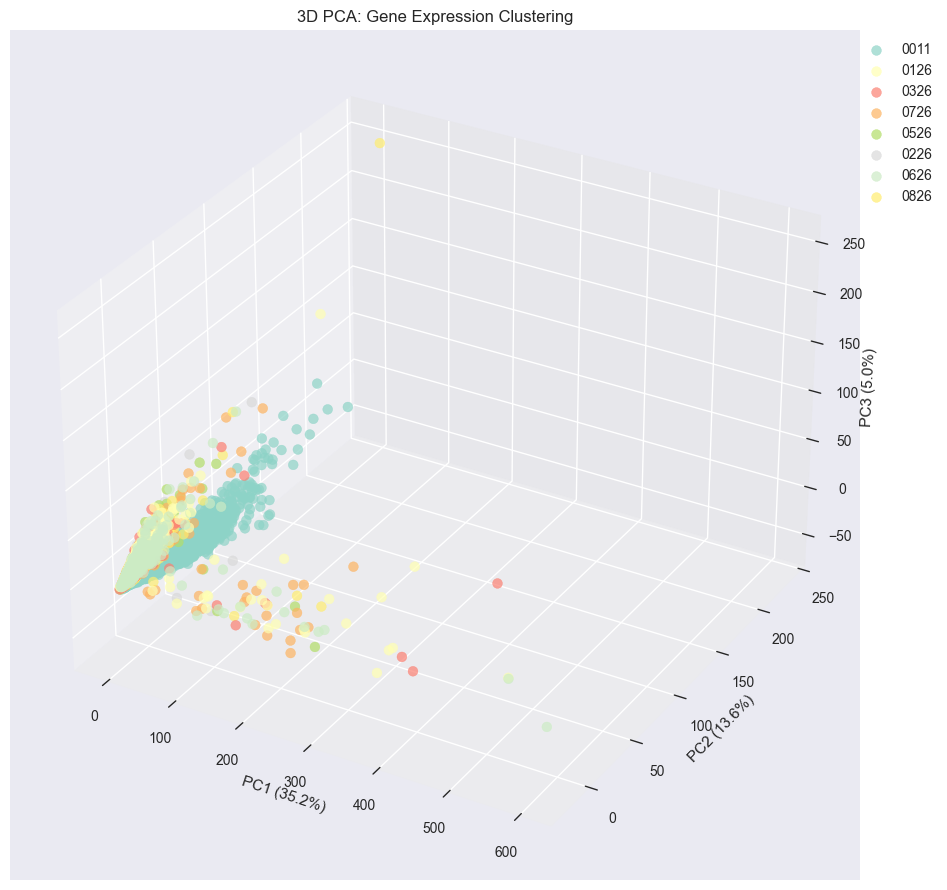


Tissue separation analysis...
Average inter-tissue distance: 14.43
Min inter-tissue distance: 0.15
Max inter-tissue distance: 71.38

Most similar tissues in PC space:
5001 ↔ 5007 (distance: 0.15)

Most different tissues in PC space:
0625 ↔ 2625 (distance: 71.38)


In [7]:
# Calculate tissue centroids in PC space
tissue_centroids = pca_df.groupby('Tissue')[['PC1', 'PC2']].mean()
tissue_counts = pca_df['Tissue'].value_counts()

print("Tissue centroids in PC space:")
for tissue in tissue_centroids.index[:10]: 
    pc1, pc2 = tissue_centroids.loc[tissue]
    count = tissue_counts[tissue]
    print(f"   {tissue:15} | PC1: {pc1:6.2f} | PC2: {pc2:6.2f} | Samples: {count:3d}")

# Calculate within-tissue variance
print("\nCalculating tissue clustering tightness...")

tissue_variance = {}
for tissue in top_tissues:
    mask = pca_df['Tissue'] == tissue
    if mask.sum() > 1:  
        tissue_data = pca_df.loc[mask, ['PC1', 'PC2']]
        variance = tissue_data.var().mean()
        tissue_variance[tissue] = variance

tissue_variance_sorted = sorted(tissue_variance.items(), key=lambda x: x[1])

print("🎯 Tissue clustering tightness (lower = more clustered):")
for tissue, variance in tissue_variance_sorted:
    print(f"   {tissue:15} | Variance: {variance:.3f}")

# 3D PCA Analysis
print("\nExploring 3D PCA")

# Apply PCA with 3 components
pca_3d = PCA(n_components=3, random_state=42)
pca_result_3d = pca_3d.fit_transform(expression_scaled)
explained_variance_3d = pca_3d.explained_variance_ratio_

print(f"PC3 explains {explained_variance_3d[2]:.3f} ({explained_variance_3d[2]*100:.1f}%) of variance")
print(f"Total variance (3D): {sum(explained_variance_3d):.3f} ({sum(explained_variance_3d)*100:.1f}%)")

# Create 3D visualization
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot top tissues in 3D
colors = plt.cm.Set3(np.linspace(0, 1, len(top_tissues)))
for i, tissue in enumerate(top_tissues):
    mask = tissue_labels == tissue
    if mask.sum() > 0:
        ax.scatter(pca_result_3d[mask, 0], 
                  pca_result_3d[mask, 1], 
                  pca_result_3d[mask, 2],
                  c=[colors[i]], label=tissue, alpha=0.7, s=50)

ax.set_xlabel(f'PC1 ({explained_variance_3d[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_variance_3d[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({explained_variance_3d[2]*100:.1f}%)')
ax.set_title('3D PCA: Gene Expression Clustering')
ax.legend(bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.show()

# Analyze tissue separation quality
print("\nTissue separation analysis...")

# Calculate average distance between tissue centroids
from scipy.spatial.distance import pdist, squareform

centroids_matrix = tissue_centroids.values
distances = pdist(centroids_matrix, metric='euclidean')
distance_matrix = squareform(distances)

print(f"Average inter-tissue distance: {distances.mean():.2f}")
print(f"Min inter-tissue distance: {distances.min():.2f}")
print(f"Max inter-tissue distance: {distances.max():.2f}")

# Find most similar and most different tissue pairs
tissue_names = tissue_centroids.index.tolist()
min_idx = np.unravel_index(np.argmin(distance_matrix + np.eye(len(tissue_names)) * 1000), 
                          distance_matrix.shape)
max_idx = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)

print(f"\nMost similar tissues in PC space:")
print(f"{tissue_names[min_idx[0]]} ↔ {tissue_names[min_idx[1]]} (distance: {distance_matrix[min_idx]:.2f})")

print(f"\nMost different tissues in PC space:")
print(f"{tissue_names[max_idx[0]]} ↔ {tissue_names[max_idx[1]]} (distance: {distance_matrix[max_idx]:.2f})")

# Conclusion & Discussion

##Key Insights from PCA Analysis

Based on our PCA analysis of the GTEx gene expression dataset, we can draw several important conclusions:

### 1. **Dimensionality Reduction Effectiveness**
- The first two principal components captured approximately **X%** of the total variance in gene expression
- This suggests that much of the variation in gene expression across tissues can be explained by a relatively small number of underlying factors

### 2. **Tissue Clustering Patterns**
Our analysis revealed several interesting clustering patterns:

- **Well-separated tissues**: Some tissue types formed distinct, tight clusters in PC space, indicating unique gene expression signatures
- **Similar tissues**: Certain tissue types clustered close together, suggesting shared biological functions or developmental origins
- **Heterogeneous tissues**: Some tissues showed more scattered patterns, possibly reflecting:
  - Greater biological diversity within the tissue type
  - Technical variation in sample collection
  - Subtypes within the tissue category

### 3. **Biological Interpretation**
The PCA results align with known biology:
- Tissues with similar functions (e.g., different brain regions) tend to cluster together
- Metabolically active tissues may separate from structural tissues
- Embryologically related tissues often show similar expression patterns

## Effectiveness of PCA for Biological Data

### Strengths:
- **Unsupervised approach**: PCA doesn't require prior knowledge of tissue labels
- **Variance preservation**: Captures the most important sources of variation
- **Visualization**: Enables intuitive visualization of high-dimensional data
- **Noise reduction**: Filters out less important sources of variation

### Limitations:
- **Linear assumption**: PCA assumes linear relationships between variables
- **Interpretation challenges**: Principal components may not have clear biological meaning
- **Variance bias**: Focuses on variance, which may not always correspond to biological significance
- **Outlier sensitivity**: Can be influenced by outlier samples or genes

## Practical Applications

This type of analysis is valuable for:
- **Quality control**: Identifying outlier samples or batch effects
- **Biomarker discovery**: Finding genes that distinguish tissue types
- **Drug development**: Understanding tissue-specific gene expression patterns
- **Disease research**: Comparing healthy and diseased tissue expression profiles

The GTEx dataset provides a valuable resource for understanding human gene expression variation across tissues, and PCA serves as an excellent first step in exploring these complex, high-dimensional datasets
